In [7]:
# 1. Import libraries
import earthaccess
import rasterio
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from datetime import datetime

In [3]:
# 2. Authenticate with Earthaccess
auth = earthaccess.login()

In [4]:
# 3. Search for MODIS NDVI data for a region (example: Kenya, 2022–2023)
results = earthaccess.search_data(
    short_name="MOD13Q1",    # MODIS Vegetation Indices
    bounding_box=(34, -4, 42, 4),   # Example: small region in Kenya
    temporal=("2022-01-01", "2023-12-31")
)

In [5]:
# 4. Download a small subset
files = earthaccess.download(results[:5], "./data")

QUEUEING TASKS | : 100%|██████████| 20/20 [00:00<00:00, 1060.53it/s]
PROCESSING TASKS | : 100%|██████████| 20/20 [14:31<00:00, 43.56s/it] 
COLLECTING RESULTS | : 100%|██████████| 20/20 [00:00<?, ?it/s]


In [3]:
data_dir = Path("./converted")
files = sorted(data_dir.glob("*.tif"))

In [8]:
ndvi_means = []
dates = []

data_dir = Path("./converted")
files = sorted(data_dir.glob("*.tif"))

for f in files:
    with rasterio.open(f) as src:
        ndvi = src.read(1).astype(float)

        # Apply MODIS scale factor
        ndvi = ndvi * 0.0001  

        # Mask out invalid values
        ndvi[ndvi < -0.2] = np.nan
        ndvi[ndvi > 1.0] = np.nan

        ndvi_mean = np.nanmean(ndvi)
        ndvi_means.append(ndvi_mean)

    # Extract date from filename (AYYYYDDD pattern)
    match = re.search(r"A(\d{7})", f.name)
    if match:
        doy = match.group(1)  # '2021353'
        dt = datetime.strptime(doy, "%Y%j")
        dates.append(dt)

print("Dates:", dates)
print("NDVI means:", ndvi_means)


Dates: [datetime.datetime(2021, 12, 19, 0, 0), datetime.datetime(2021, 12, 19, 0, 0), datetime.datetime(2021, 12, 19, 0, 0), datetime.datetime(2021, 12, 19, 0, 0), datetime.datetime(2022, 1, 1, 0, 0)]
NDVI means: [0.4264337470238135, 0.5255369903664796, 0.2435351480675216, 0.5988336910434181, 0.5964294504388813]


In [ ]:
# 7. Detect anomalies (potential invasive events)
ndvi_series = pd.Series(ndvi_means, index=pd.to_datetime(dates))

rolling_mean = ndvi_series.rolling(window=3, center=True).mean()

anomalies = ndvi_series.nlargest(10)

print("Anomalies: ", anomalies)

Anomalies:  2021-12-19    0.598834
2022-01-01    0.596429
2021-12-19    0.525537
2021-12-19    0.426434
2021-12-19    0.243535
dtype: float64


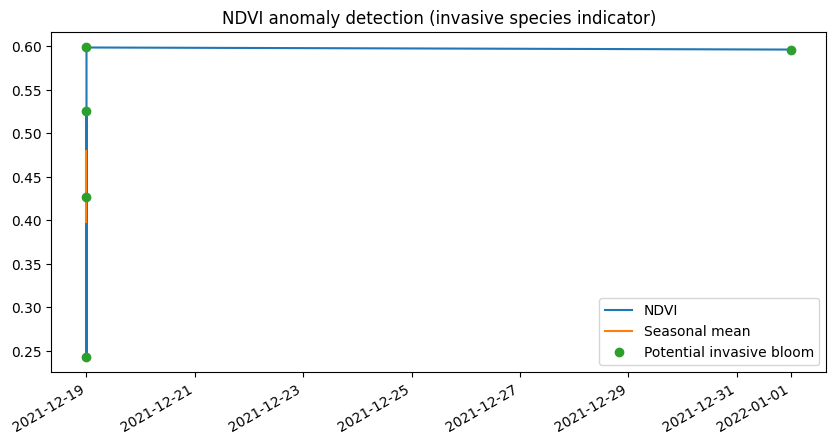

In [22]:
# 8. Plot results
plt.figure(figsize=(10,5))
ndvi_series.plot(label="NDVI")
rolling_mean.plot(label="Seasonal mean")
anomalies.plot(style="o", label="Potential invasive bloom")
plt.legend()
plt.title("NDVI anomaly detection (invasive species indicator)")
plt.show()


In [24]:
#9. Export processed data to frontend
df = pd.DataFrame({
    "time": ndvi_series.index,
    "ndvi":ndvi_series.values,
    "rolling_mean":rolling_mean.values,
    "anomaly":ndvi_series.index.isin(anomalies.index).astype(int)
})

df.to_csv("ndvi_anomalies.csv",index=False)
print("CSV saved with shape: ", df.shape)

CSV saved with shape:  (5, 4)
